In [1]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm

/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /home/yannick/bin/anaconda3/envs/py27/lib/python2.7/argparse.pyc, but /home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


In [2]:
def gen_sample(n, mus, sigmas):
    return np.array([mus + stats.norm.rvs(size = n, loc = 0, scale = sigmas[i]) for i in np.arange(len(sigmas)) ])

def gen_mus_sigma(nb_stateux, nb_samples):
    return (stats.uniform.rvs(size=nb_samples, loc=0, scale=200), stats.uniform.rvs(size=nb_stateux, loc=0, scale=40))

nb_stateux = 7
sample_length = 10

(mus, sigma) = gen_mus_sigma(nb_stateux, sample_length)
sample = gen_sample(sample_length, mus, sigma)
print len(sample), len(sample[0])
print mus
print sigma
print sample
print [np.mean([sample[i, j] for i in np.arange(len(sigma))]) for j in np.arange(len(mus))]

print sample.shape

7 10
[ 162.24009551   91.4285223   174.56973426  125.55428022  161.60040067
  169.23709891  185.56555089   91.85135561   84.47767457  179.65897542]
[ 21.38303043  12.60143185   2.56099709   7.34594796  16.34635367
  17.86243362  37.2129251 ]
[[ 146.13331399   80.58656486  170.3391262   123.90902538  145.19846667
   183.80629678  181.50820343  110.19856587   92.97082215  165.58953037]
 [ 171.83865153   83.07315743  184.53251626  115.73028073  155.05701749
   173.62612795  199.87800487   90.84715652   85.9415822   163.01453984]
 [ 162.82147452   90.53960006  173.58513218  132.94872322  159.58020773
   167.31443897  187.94374504   93.28853976   86.15994293  180.50565526]
 [ 173.7414296    86.48108239  157.12697932  108.39286669  166.1823561
   166.97432026  173.24195171   94.48004491   94.95372799  169.59678454]
 [ 142.6128171    98.85110072  150.88126495  135.27678947  174.83310397
   188.03469474  177.01647968   75.01248874   98.92327053  210.66679394]
 [ 149.42804966   60.13413227  171

In [3]:
import numpy as np
import pymc as pm

(nb_stateux, sample_length) = sample.shape

v_mus = np.array([pm.Normal("mu%d" % i, mu=0, tau=0.001) for i in np.arange(sample_length)])
v_sigmas = [pm.Uniform("sigma%d" % k, lower=0, upper=100) for k in np.arange(nb_stateux)]
v_taus = [pm.Lambda("tau%d" % k, lambda sigma=v_sigmas[k]: 1/sigma**2) for k in np.arange(nb_stateux)]

x = np.array([[pm.Normal("x%d_%d" % (k,i), mu=v_mus[i], tau=v_taus[k], 
                         observed=True, value=np.array(sample[k,i])) for i in np.arange(sample_length)]
              for k in np.arange(nb_stateux)])

mcmc = pm.MCMC([v_mus, v_sigmas, v_taus, x])
mcmc.sample(5000,1000)

mu_traces = [np.array(mcmc.trace('mu%d' % k)[:]) for k in np.arange(sample_length)]
sigma_traces = [np.array(mcmc.trace("sigma%d" % i)[:]) for i in np.arange(nb_stateux)]

 [-----------------100%-----------------] 5000 of 5000 complete in 6.3 sec

In [4]:
%history -f 7stateux_model.py -l 1

File u'7stateux_model.py' exists. Overwrite? n
Aborting.


156.535610484
81.658085458
167.30250582
121.793118092
151.536698491
168.474361567
181.920128304
92.7839746213
87.1917856499
169.122307508


/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


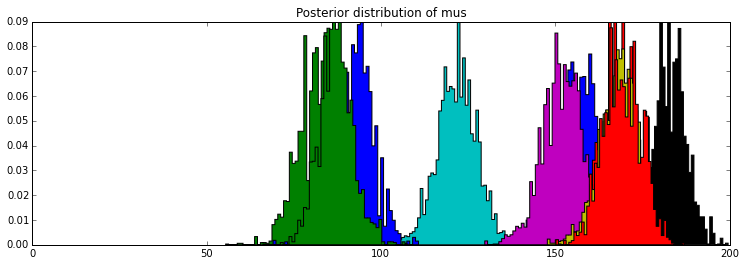

In [5]:
figsize(12.5, 4)
plt.title("Posterior distribution of mus")
for i in np.arange(sample_length):
    plt.hist(mu_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,200))
    print (mu_traces[i].mean())

11.4133176319
12.5537485715
10.0798645669
12.9131390724
23.9494376975
17.6672789091
49.1550577114


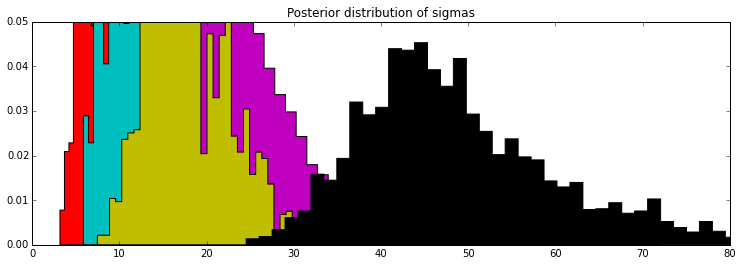

In [6]:
figsize(12.5, 4)
plt.title("Posterior distribution of sigmas")
for i in np.arange(nb_stateux):
    plt.hist(sigma_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,80))
    print (sigma_traces[i].mean())

In [10]:
# Now going parallel

from IPython.parallel import Client
client = Client()

direct         = client[:]
direct.block   = True
print (direct)

def checkhostname():
    import socket
    return socket.gethostname()

direct.apply(checkhostname)

import numpy as np
with direct.sync_imports():
    import pymc as pm
    import numpy as np

<DirectView [0, 1, 2, 3,...]>
importing pymc on engine(s)
importing numpy on engine(s)


In [11]:
export_dict = {k: globals()[k] for k in ('sample', 'nb_stateux')}
direct.push(export_dict, block=True)

model_script = open('7stateux_model.py').read()
print model_script

import numpy as np
import pymc as pm

(nb_stateux, sample_length) = sample.shape

v_mus = np.array([pm.Normal("mu%d" % i, mu=0, tau=0.001) for i in np.arange(sample_length)])
v_sigmas = [pm.Uniform("sigma%d" % k, lower=0, upper=100) for k in np.arange(nb_stateux)]
v_taus = [pm.Lambda("tau%d" % k, lambda sigma=v_sigmas[k]: 1/sigma**2) for k in np.arange(nb_stateux)]

x = np.array([[pm.Normal("x%d_%d" % (k,i), mu=v_mus[i], tau=v_taus[k], 
                         observed=True, value=np.array(sample[k,i])) for i in np.arange(sample_length)]
              for k in np.arange(nb_stateux)])

mcmc = pm.MCMC([v_mus, v_sigmas, v_taus, x])
mcmc.sample(5000,1000)

mu_traces = [np.array(mcmc.trace('mu%d' % k)[:]) for k in np.arange(sample_length)]
sigma_traces = [np.array(mcmc.trace("sigma%d" % i)[:]) for i in np.arange(nb_stateux)]



In [12]:
direct.execute(model_script)

<AsyncResult: finished>

In [13]:
def get_trace(var_name):
    all_traces = direct.pull(var_name)
    a = len(all_traces)
    b = len(all_traces[0])

    y = [np.array([all_traces[i][j] for i in range(a)]).flatten() for j in range(b)]
    
    return y

mu_traces = get_trace("mu_traces")
sigma_traces = get_trace("sigma_traces")

print mu_traces
print len(mu_traces), len(mu_traces[0])

[array([ 155.41201205,  152.6069508 ,  161.11038227, ...,  159.26619286,
        159.26619286,  157.60941787]), array([ 83.80046615,  83.80046615,  83.80046615, ...,  80.60369909,
        80.60369909,  80.60369909]), array([ 177.84569493,  177.84569493,  177.84569493, ...,  169.42129028,
        169.42129028,  169.42129028]), array([ 109.60859323,  121.16692045,  121.16692045, ...,  125.22291796,
        125.22291796,  125.22291796]), array([ 149.79899796,  153.57501211,  155.08748611, ...,  152.74140446,
        150.89096591,  150.89096591]), array([ 168.77709344,  168.77709344,  168.77709344, ...,  166.74393043,
        166.74393043,  166.74393043]), array([ 186.91379619,  186.91379619,  186.91379619, ...,  172.69359518,
        172.69359518,  172.69359518]), array([ 78.79413239,  78.79413239,  78.79413239, ...,  89.84395648,
        86.30614891,  87.10075857]), array([ 88.0760554 ,  80.52093495,  80.52093495, ...,  90.16020078,
        90.16020078,  98.54267902]), array([ 176.883019

155.017071333 162.240095506
80.9807370314 91.4285222968
165.635934455 174.569734258
120.398308689 125.554280218
149.968066358 161.600400673
164.946711284 169.237098908
180.082113663 185.565550891
91.0050720839 91.8513556087
86.3689339788 84.4776745725
167.30709848 179.658975419


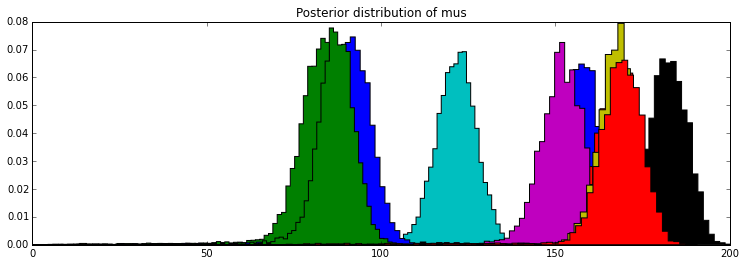

In [14]:
figsize(12.5, 4)
plt.title("Posterior distribution of mus")
for i in np.arange(sample_length):
    plt.hist(mu_traces[i], bins=100, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,200))
    print (mu_traces[i].mean()), mus[i]

(13.788150873611528, 11.491564634573624, 21.383030426817392)
(14.483658007986124, 12.21779243116136, 12.60143185336387)
(11.890141971896456, 9.6169300048991158, 2.5609970866651954)
(14.222295932155431, 12.093184624738887, 7.3459479567563202)
(25.555678308136883, 23.102467914979655, 16.346353674206782)
(19.190820183938055, 17.066865673928671, 17.862433622536713)
(50.372252808870748, 47.821921498359956, 37.21292509976842)


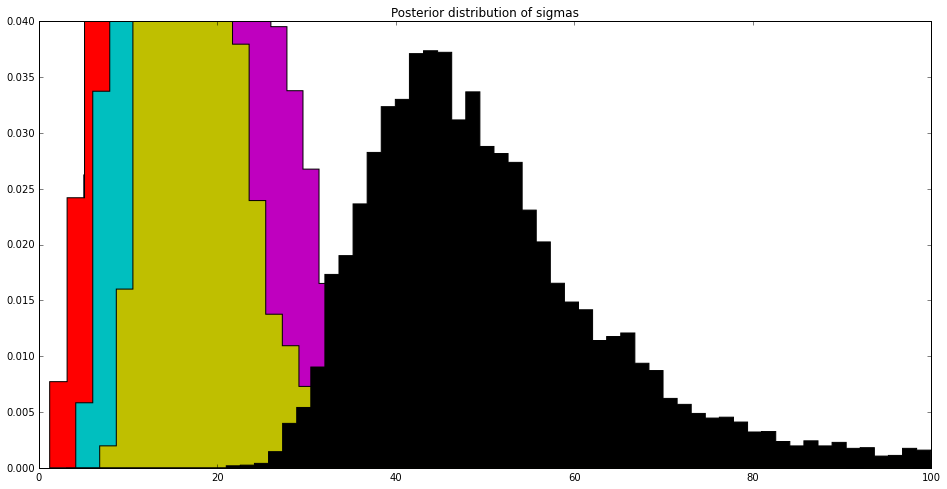

In [15]:
figsize(16, 8)
plt.title("Posterior distribution of sigmas")
for i in np.arange(nb_stateux):
    plt.hist(sigma_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,100))
    print (sigma_traces[i].mean(), np.median(sigma_traces[i]), sigma[i])